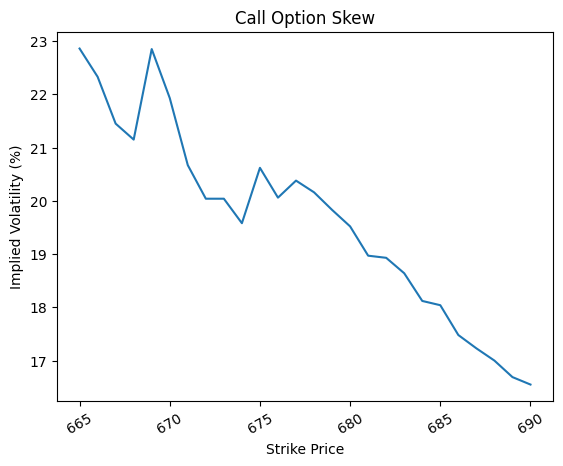

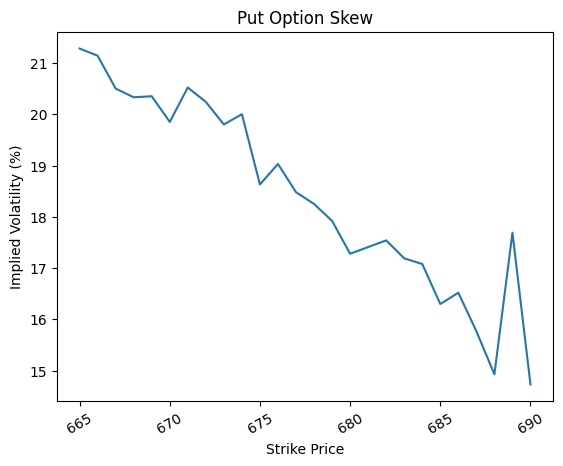

In [2]:
#IMPLIED VOLATILITY SKEW

from blackScholesChain import impliedVol
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from pandas import DataFrame, Series

#PARAMETERS
stock = yf.Ticker("SPY")
strikes = 26
r = 0.04 #risk-free rate
expiration = "2026-01-30" #YYYY-MM-DD

#IMPLIED VOL CALCULATIONS
c,p = DataFrame(stock.option_chain(date = expiration)[0]),DataFrame(stock.option_chain(date = expiration)[1])
c.set_index("strike", inplace = True), p.set_index("strike", inplace = True)
S = stock.info["regularMarketPrice"]
c["Intrinsic Value"] = Series(S - c.index, index = c.index).map(lambda x: max(0,x))
p["Intrinsic Value"] = Series(p.index - S, index = p.index).map(lambda x: max(0,x))
c = c.iloc[(c.index.get_loc(c["Intrinsic Value"].idxmin()) - strikes//2):(c.index.get_loc(c["Intrinsic Value"].idxmin()) + strikes//2), 2]
p = p.iloc[(p.index.get_loc(p["Intrinsic Value"][p["Intrinsic Value"] != 0].idxmin()) - strikes//2):(p.index.get_loc(p["Intrinsic Value"][p["Intrinsic Value"] != 0].idxmin()) + strikes//2), 2]
t = (dt.datetime(int(expiration[:4]),int(expiration[5:7]),int(expiration[8:]))-dt.datetime.now()).days/365
call, put = impliedVol(S,c.index,r,t,c,p)

#PLOT
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax1.plot(call.index, call.astype(float)), ax2.plot(put.index, put.astype(float))
ax1.set(xlabel = "Strike Price",ylabel = "Implied Volatility (%)", title = "Call Option Skew"), ax1.tick_params(axis = "x", labelrotation = 30)
ax2.set(xlabel = "Strike Price",ylabel = "Implied Volatility (%)", title = "Put Option Skew"), ax2.tick_params(axis = "x", labelrotation = 30);

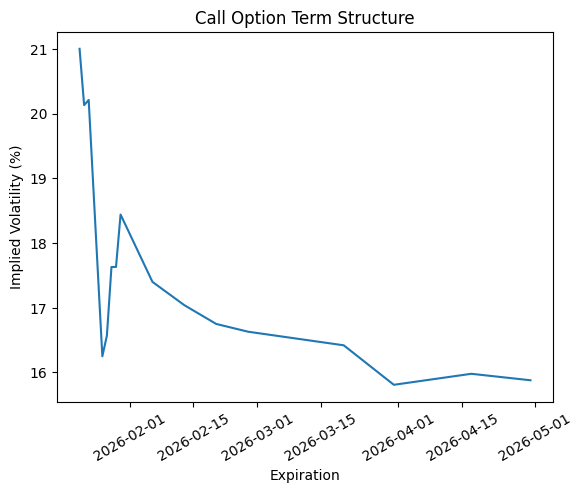

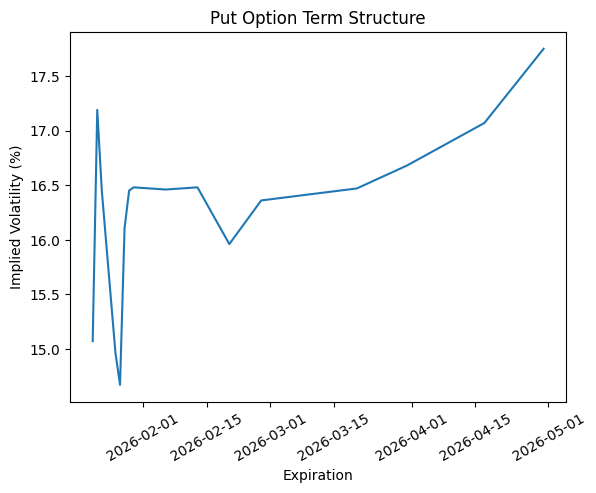

In [4]:
#IMPLIED VOLATILITY TERM STRUCTURE

from blackScholesChain import impliedVol
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas import DataFrame, Series

#PARAMETERS
stock = yf.Ticker("SPY")
strike = 680
r = 0.04 #risk-free rate
no_expirations = 16 #<= len(stock.options)

#IMPLIED VOL CALCULATIONS
dates = np.array(stock.options[1:no_expirations+1], dtype = "datetime64[D]", order = "K", subok = False, ndmin = 0)
t_till = np.array(dates-np.full(no_expirations, fill_value = dt.date.today(), dtype = "datetime64[D]"), dtype = "float64")/365 #time till expiration; in years
call = Series(index = dates, name = "Call Implied Volatilities")
put = Series(index = dates, name = "Put Implied Volatilities")
for i,t in enumerate(t_till):
    c,p = impliedVol(stock.info["regularMarketPrice"],[strike], r, t,
                     stock.option_chain(date = str(dates[i]))[0].query(f"strike == {strike}")["lastPrice"], stock.option_chain(date = str(dates[i]))[1].query(f"strike == {strike}")["lastPrice"])
    call.iloc[i], put.iloc[i] = c.iloc[0],p.iloc[0]

#PLOT
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax1.plot(call.index, call), ax2.plot(put.index, put)
ax1.set(xlabel = "Expiration",ylabel = "Implied Volatility (%)", title = "Call Option Term Structure"), ax1.tick_params(axis = "x", labelrotation = 30)
ax2.set(xlabel = "Expiration",ylabel = "Implied Volatility (%)", title = "Put Option Term Structure"), ax2.tick_params(axis = "x", labelrotation = 30);

In [15]:
from blackScholesChain import impliedVol
import yfinance as yf
import numpy as np
import datetime as dt
from pandas import DataFrame, Series
import plotly.graph_objects as go

#PARAMETERS
stock = yf.Ticker("SPY")
strikes = 10
r = 0.0375 #risk-free rate
no_expirations = 4 #<= len(stock.options)

#IMPLIED VOL CALCULATIONS
dates = np.array(stock.options[1:no_expirations+1], dtype = "datetime64[D]", order = "K", subok = False, ndmin = 0)
t_till = np.array(dates-np.full(no_expirations, fill_value = dt.date.today(), dtype = "datetime64[D]"), dtype = "float64")/365 #time till expiration; in years
S = stock.info["regularMarketPrice"]

k = 0
for i,t in enumerate(t_till):
    c,p = DataFrame(stock.option_chain(date = str(dates[i]))[0]),DataFrame(stock.option_chain(date = str(dates[i]))[1])
    c.set_index("strike", inplace = True), p.set_index("strike", inplace = True)
    c["Intrinsic Value"] = Series(S - c.index, index = c.index).map(lambda x: max(0,x))
    p["Intrinsic Value"] = Series(p.index - S, index = p.index).map(lambda x: max(0,x))
    c = c.iloc[(c.index.get_loc(c["Intrinsic Value"].idxmin()) - strikes//2):(c.index.get_loc(c["Intrinsic Value"].idxmin()) + strikes//2), 2]
    p = p.iloc[(p.index.get_loc(p["Intrinsic Value"][p["Intrinsic Value"] != 0].idxmin()) - strikes//2):(p.index.get_loc(p["Intrinsic Value"][p["Intrinsic Value"] != 0].idxmin()) + strikes//2), 2]
    if k == 0:
        call, put = DataFrame(columns = c.index), DataFrame(columns = p.index)
        call.index.name = "Call"
        put.index.name = "Put"
        k += 1
    call.loc[dates[i]], put.loc[dates[i]] = impliedVol(S,c.index,r,t,c,p)

#print(f"{call.iloc[:,:6]}\n\n{put.iloc[:,:6]}")

#PLOT
X,Y = np.meshgrid(c.index, call.index)
fig = go.Figure(data = [go.Surface(x=X, y=Y, z=np.array(call), colorscale = "viridis")])
fig.update_layout(title = "Implied Volatility Surface", scene = dict(xaxis_title="Strike Price", yaxis_title = "Expiration", zaxis_title = "Implied Volatility (%)"), width = 800, height = 600, template="plotly_dark", paper_bgcolor = "#1E1E1E", plot_bgcolor = "#1E1E1E")
fig.update_scenes(zaxis = {"tickformat":".1f"}) #why is this still one 2dp?
fig.show()